# Loading in Packages and Raw Data

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy import linalg as LA
from datetime import datetime
import arviz as az

In [ ]:
import sys
!{sys.executable} -m pip install pystan

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.3/45.3 MB 36.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 95.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 8.6 MB/s eta 0:00:00


In [ ]:
#loading in pystan
import stan
#loading in the following packages which allow stan to run in colab
import nest_asyncio
import asyncio

In [ ]:
#to run this code, upload the proper files to your google drive and
# mount your drive as is done here
from google.colab import drive
drive.mount('/content/drive')

votes_2012 = pd.read_csv('/content/drive/MyDrive/Election Data/Vote Shares 2012.csv', sep=',', header = 0)

#turning the percentage text column to a string
votes_2012['Obama Share'] = votes_2012['Obama Share'].str.rstrip('%').astype('float') / 100.0
polls = pd.read_csv('/content/drive/MyDrive/Election Data/president_general_polls_2016.csv', sep=',', header = 0)
#converting the end date of each pull to a date and then getting the number of days until the election
# as an integer
polls['enddate'] = pd.to_datetime(polls['enddate'])
polls['daystoelection'] = datetime(2016, 11, 7) - polls['enddate']
polls['daystoelection'] = pd.to_numeric(polls['daystoelection'].dt.days, downcast='integer')

Mounted at /content/drive


In [ ]:
#getting the poll data needed for each state and omitting Wash. D.C.
# as done in the paper
#this states array is used for indexing and filtering data
states = np.array(votes_2012.loc[votes_2012['STATE'] != 'Dist. of Col.']['STATE'])[1:]

# Raw Poll Data

In [ ]:
#this is the code for using the raw poll data
data_list_16 = []
for i in range(50):
  tmp1 = polls.loc[polls.state == states[i]][['state','daystoelection', 'samplesize', 'rawpoll_clinton']].drop_duplicates()
  #when I first did this I used np.floor which I don't think is appropriate
  #I also used the rawpoll data rather than adjusted polling data
  #I think it would be more appropriate to use adjusted polling data
  tmp1['suff.stat'] = np.floor(tmp1['samplesize']*tmp1['rawpoll_clinton']/100)
  total = tmp1.groupby(['daystoelection']).sum().reset_index()
  total['rawpoll_clinton'] = total['suff.stat']/total['samplesize']
  total = total.loc[total['daystoelection'] <= 112]
  total.set_index('daystoelection', inplace=True)
  total = total.reindex(np.arange(0,112), fill_value = 0)
  total['state'] = states[i]
  data_list_16.append(total)


In [ ]:
master_list_16 = []
for i in range(50):
  tmp = data_list_16[i][['samplesize', 'suff.stat']]
  tmp_list_2 = []
  for j in range(112):
    tmp_list_2.append(tmp.iloc[j].dropna().astype(int).tolist())
  master_list_16.append(tmp_list_2)


# Adjusted Poll Data

In [ ]:
#this is the code for getting the adjusted poll data
second_data_list_16 = []
for i in range(50):
  #using adjusted poll instead of raw poll
  tmp1 = polls.loc[polls.state == states[i]][['state','daystoelection', 'samplesize', 'adjpoll_clinton']].drop_duplicates()
  #when I first did this I used np.floor which I don't think is appropriate
  #I also used the rawpoll data rather than adjusted polling data
  #I think it would be more appropriate to use adjusted polling data
  tmp1['suff.stat'] = np.rint(tmp1['samplesize']*tmp1['adjpoll_clinton']/100)
  total = tmp1.groupby(['daystoelection']).sum().reset_index()
  total['adjpoll_clinton'] = total['suff.stat']/total['samplesize']
  total = total.loc[total['daystoelection'] <= 112]
  total.set_index('daystoelection', inplace=True)
  total = total.reindex(np.arange(0,112), fill_value = 0)
  total['state'] = states[i]
  second_data_list_16.append(total)

In [ ]:
second_master_list_16 = []
for i in range(50):
  tmp = second_data_list_16[i][['samplesize', 'suff.stat']]
  tmp_list_2 = []
  for j in range(112):
    tmp_list_2.append(tmp.iloc[j].dropna().astype(int).tolist())
  second_master_list_16.append(tmp_list_2)


# Adjusted Poll Data Filtered by Quality of Poll

In [ ]:
#this is the code for getting the adjusted poll data
clinton_data_list_16 = []
#gets indicies of rows with higher grades
ind = polls['grade'].isin(['A+', 'A-', 'A', 'B+', 'B'])
for i in range(50):
  #filtering data based on poll quality
  tmp = polls[ind]
  #using adjusted poll instead of raw poll
  tmp1 = tmp.loc[tmp.state == states[i]][['state','daystoelection', 'samplesize', 'adjpoll_clinton', 'poll_id']].drop_duplicates(subset =['poll_id'])
  #when I first did this I used np.floor which I don't think is appropriate
  #I also used the rawpoll data rather than adjusted polling data
  #I think it would be more appropriate to use adjusted polling data
  tmp1['suff.stat'] = np.rint(tmp1['samplesize']*tmp1['adjpoll_clinton']/100)
  total = tmp1.groupby(['daystoelection']).sum().reset_index()
  total['adjpoll_clinton'] = total['suff.stat']/total['samplesize']
  total = total.loc[total['daystoelection'] <= 112]
  total.set_index('daystoelection', inplace=True)
  total = total.reindex(np.arange(0,112), fill_value = 0)
  total['state'] = states[i]
  clinton_data_list_16.append(total)

In [ ]:
clinton_master_list_16 = []
for i in range(50):
  tmp = clinton_data_list_16[i][['samplesize', 'suff.stat']]
  tmp_list_2 = []
  for j in range(112):
    tmp_list_2.append(tmp.iloc[j].dropna().astype(int).tolist())
  clinton_master_list_16.append(tmp_list_2)


# Trump Data

In [ ]:
#this is the code for getting the adjusted poll data
trump_data_list_16 = []
#gets indicies of rows with higher grades
ind = polls['grade'].isin(['A+', 'A-', 'A', 'B+', 'B'])
for i in range(50):
  #filtering data based on poll quality
  tmp = polls[ind]
  #using adjusted poll instead of raw poll
  tmp1 = tmp.loc[tmp.state == states[i]][['state','daystoelection', 'samplesize', 'adjpoll_trump', 'poll_id']].drop_duplicates(subset =['poll_id'])
  #when I first did this I used np.floor which I don't think is appropriate
  #I also used the rawpoll data rather than adjusted polling data
  #I think it would be more appropriate to use adjusted polling data
  tmp1['suff.stat'] = np.rint(tmp1['samplesize']*tmp1['adjpoll_trump']/100)
  total = tmp1.groupby(['daystoelection']).sum().reset_index()
  total['adjpoll_trump'] = total['suff.stat']/total['samplesize']
  total = total.loc[total['daystoelection'] <= 112]
  total.set_index('daystoelection', inplace=True)
  total = total.reindex(np.arange(0,112), fill_value = 0)
  total['state'] = states[i]
  trump_data_list_16.append(total)

In [ ]:
trump_master_list_16 = []
for i in range(50):
  tmp = trump_data_list_16[i][['samplesize', 'suff.stat']]
  tmp_list_2 = []
  for j in range(112):
    tmp_list_2.append(tmp.iloc[j].dropna().astype(int).tolist())
  trump_master_list_16.append(tmp_list_2)


# Code for Getting Data for the First n Weeks of Campaign

In [ ]:
import copy
#creating data for the model fit with all 16 weeks of data, 14 weeks, ..., 2 weeks
def nweeks(data = clinton_master_list_16, numw=2):
  tmp = []
  #this is to make a copy of the original data without alternating it
  dat = copy.deepcopy(data)
  for i in range(50):
    tmp_2 = dat[i]
    for j in range(112 - 7*numw):
      tmp_2[j] = [0,0]
    tmp.append(tmp_2)
  return(tmp)
clinton_master_list_4 = nweeks(numw=4)
clinton_master_list_8 = nweeks(numw=8)
clinton_master_list_12 = nweeks(numw=12)
trump_master_list_4 = nweeks(data = trump_master_list_16, numw=4)
trump_master_list_8 = nweeks(data = trump_master_list_16, numw=8)
trump_master_list_12 = nweeks(data = trump_master_list_16, numw=12)


# First Model Where All 50 Betas Get Fit (Used in Presentation but Only in Fig. 4 in Paper)

In [ ]:
#data for model
model_data_sixt_weeks = {'N': 50,
              'h': h,
              's': np.sqrt(.1),
              'D': 112,
              'Z': 2,
              'polls': master_list_16, }

In [ ]:
elec_model = """
data {
  int<lower=0> N;         // number of states
  array[N] real h;              // long-term forecast
  real<lower=0> s; // prior variance for beta_iJ
  int<lower=0> D; // number of days
  int<lower=0> Z; //num cols for ['samplesize', 'suff.stat]
  array[N,D,Z] int<lower=0> polls;
}
parameters {
  array[N,D] real betas;
  array[D] real deltas;
  real<lower = 0> s_delta;
  real<lower=0> s_beta;
}
model {
  for (n in 1:N) {
    betas[n,1] ~ normal(h[n], s);
    }

    for (n in 1:N) {
      for (d in 1:(D-1)) {
      betas[n, d+1] ~ normal( betas[n,d], s_beta);
      }
    }

  deltas[1] ~ normal(0, s_delta);
  for (d in 2:D) {
    deltas[d] ~ normal(deltas[d-1], s_delta);
  }

  for (n in 1:N) {
    for (d in 1:D) {
      real p = inv_logit(betas[n,d] + deltas[d]);
      polls[n,d,2] ~ binomial(polls[n,d,1], p);
    }
  }
}
generated quantities{
  array[N,D] real<lower=0, upper=1> pis;
 for (n in 1:N) {
    for (d in 1:D) {
      pis[n,d] = inv_logit(betas[n,d] + deltas[d]);
    }
 }
}
"""


#posterior = stan.build(schools_code, data=schools_data)
#fit = posterior.sample(num_chains=4, num_samples=1000)
#eta = fit["eta"]  # array with shape (8, 4000)
#df = fit.to_frame()  # pandas `DataFrame, requires pandas

In [ ]:
#asyncio.run(asyncio.sleep(1))
nest_asyncio.apply()
posterior_sixt = stan.build(elec_model, data=model_data_sixt_weeks, random_seed = 1)

In [ ]:
fit = posterior_sixt.sample(num_chains = 4, num_samples = 500, num_warmup = 500)

# Model Where $\beta_{ij} = \beta_{it[J]}$ and $t = 0, \ldots,\frac{ 112}{4}$

In [ ]:
#this is the model that only estimates N/4 beta values
elec_model = """
data {
  int<lower=0> N;         // number of states
  array[N] real h;              // long-term forecast
  real<lower=0> s; // prior variance for beta_iJ
  int<lower=0> D; // number of days
  int<lower=0> Z; //num cols for ['samplesize', 'suff.stat]
  array[N,D,Z] int<lower=0> polls;
  int<lower=0> P; //number of periods for beta
  array[D] int I; //indexing array for the betas
}
parameters {
  array[N,P] real betas;
  real<lower = 0> s_delta;
  real<lower=0> s_beta;
  array[D] real deltas;

}

model {
  for (n in 1:N) {
    betas[n,1] ~ normal(h[n], s);
    }

    for (n in 1:N) {
      for (p in 1:(P-1)) {
      betas[n, p+1] ~ normal( betas[n,p], s_beta);
      }
    }

  for (d in 2:D) {
    deltas[d] ~ normal(deltas[d-1], s_delta);
  }

  for (n in 1:N) {
    for (d in 1:D) {
      real p = inv_logit(betas[n,I[d]] + deltas[d]);
      polls[n,d,2] ~ binomial(polls[n,d,1], p);
    }
  }
}
generated quantities{
  array[N,D] real<lower=0, upper=1> pis;
 for (n in 1:N) {
    for (d in 1:D) {
      pis[n,d] = inv_logit(betas[n,I[d]] + deltas[d]);
    }
 }
}
"""


# Fully Prepped Data for Different Pystan Models

In [ ]:
#indexing array
I = np.repeat(np.arange(29)[1:], 4).astype(int).tolist()

In [ ]:
#overall h, the ovarall vote share expected for Hillary Clinton in 2016
# using the time for change model based on this paper: https://www-jstor-org.wv-o-ursus-proxy02.ursus.maine.edu/stable/pdf/20452296.pdf?refreqid=fastly-default%3A6625b0d758ce04997ab209d850e4dd9f&ab_segments=&origin=&initiator=&acceptTC=1
# and data from these sources: https://fred.stlouisfed.org/series/A191RL1Q225SBEA, https://news.gallup.com/poll/116479/barack-obama-presidential-job-approval.aspx,
# https://www.presidency.ucsb.edu/statistics/elections/2012
h = 51.417 + .604*1.3 + .109*7.67 -4.265
diff = (h - 51.1)/100

In [ ]:
#creating h_i for each state as described in the paper
Obama = votes_2012[['STATE', 'Obama Share']]
Obama['h_i'] = Obama['Obama Share'] + diff
Obama.loc[Obama.STATE == 'Arkansas', 'h_i'] = Obama.loc[Obama.STATE == 'Arkansas', 'h_i'] + .06
Obama.loc[Obama.STATE == 'New York', 'h_i'] = Obama.loc[Obama.STATE == 'New York', 'h_i'] - .06
h_i = Obama[Obama['STATE'] != 'Dist. of Col.']['h_i'][1:].to_list()
t_h_i = np.ones(50) - h_i

In [ ]:
#clinton prior forecast
c_h = []
for i in range(50):
  c_h.append(np.log(h_i[i]/(1-h_i[i])))

In [ ]:
#trump prior forecast
t_h = []
for i in range(50):
  t_h.append(np.log(t_h_i[i]/(1-t_h_i[i])))

In [ ]:
clinton_model_data_16_weeks = {'N': 50,
              'h': c_h,
              's': np.sqrt(.05),
              'D': 112,
              'Z': 2,
              'polls': clinton_master_list_16,
              'I': I,
              'P': 28            }

In [ ]:
trump_model_data_16_weeks = {'N': 50,
              'h': t_h,
              's': np.sqrt(.05),
              'D': 112,
              'Z': 2,
              'polls': trump_master_list_16,
              'I': I,
              'P': 28            }

In [ ]:
clinton_model_data_4_weeks = {'N': 50,
              'h': c_h,
              's': np.sqrt(.05),
              'D': 112,
              'Z': 2,
              'polls': clinton_master_list_4,
              'I': I,
              'P': 28            }

In [ ]:
trump_model_data_4_weeks = {'N': 50,
              'h': t_h,
              's': np.sqrt(.05),
              'D': 112,
              'Z': 2,
              'polls': trump_master_list_4,
              'I': I,
              'P': 28            }

In [ ]:
clinton_model_data_8_weeks = {'N': 50,
              'h': c_h,
              's': np.sqrt(.05),
              'D': 112,
              'Z': 2,
              'polls': clinton_master_list_8,
              'I': I,
              'P': 28            }

In [ ]:
trump_model_data_8_weeks = {'N': 50,
              'h': t_h,
              's': np.sqrt(.05),
              'D': 112,
              'Z': 2,
              'polls': clinton_master_list_8,
              'I': I,
              'P': 28            }

In [ ]:
clinton_model_data_12_weeks = {'N': 50,
              'h': c_h,
              's': np.sqrt(.05),
              'D': 112,
              'Z': 2,
              'polls': clinton_master_list_12,
              'I': I,
              'P': 28            }

In [ ]:
trump_model_data_12_weeks = {'N': 50,
              'h': t_h,
              's': np.sqrt(.05),
              'D': 112,
              'Z': 2,
              'polls': trump_master_list_12,
              'I': I,
              'P': 28            }

# Run This for Stan to Work

In [ ]:
nest_asyncio.apply()

# 16 Week Models

In [ ]:
nest_asyncio.apply()
post_clinton_16_weeks = stan.build(elec_model, data=clinton_model_data_16_weeks, random_seed = 1)

Building...



Building: 29.9s, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.


In [ ]:
clintonfit16weeks = post_clinton_16_weeks.sample(num_chains = 3, num_samples = 500, num_warmup = 500,
                                       init = [{"deltas[1]": 0}, {"deltas[1]": 0}, {"deltas[1]": 0}])

In [ ]:
post_trump_16_weeks = stan.build(elec_model, data=trump_model_data_16_weeks, random_seed = 1)

In [ ]:
trumpfit16weeks = post_trump_16_weeks.sample(num_chains = 3, num_samples = 500, num_warmup = 500,
                                       init = [{"deltas[1]": 0}, {"deltas[1]": 0}, {"deltas[1]": 0}])

# 12 Week Models

In [ ]:
post_clinton_12_weeks = stan.build(elec_model, data=clinton_model_data_12_weeks, random_seed = 1)

In [ ]:
clintonfit12weeks = post_clinton_12_weeks.sample(num_chains = 3, num_samples = 500, num_warmup = 500)

Sampling:   0%
Sampling:   0% (1/3000)
Sampling:   0% (2/3000)
Sampling:   0% (3/3000)
Sampling:   3% (102/3000)
Sampling:   7% (201/3000)
Sampling:  10% (300/3000)
Sampling:  13% (400/3000)
Sampling:  17% (500/3000)
Sampling:  20% (600/3000)
Sampling:  23% (700/3000)
Sampling:  27% (800/3000)
Sampling:  30% (900/3000)
Sampling:  33% (1000/3000)
Sampling:  37% (1100/3000)
Sampling:  40% (1200/3000)
Sampling:  43% (1300/3000)
Sampling:  43% (1301/3000)
Sampling:  47% (1401/3000)
Sampling:  50% (1502/3000)
Sampling:  50% (1503/3000)
Sampling:  53% (1602/3000)
Sampling:  57% (1701/3000)
Sampling:  60% (1800/3000)
Sampling:  63% (1900/3000)
Sampling:  67% (2000/3000)
Sampling:  70% (2100/3000)
Sampling:  73% (2200/3000)
Sampling:  77% (2300/3000)
Sampling:  80% (2400/3000)
Sampling:  83% (2500/3000)
Sampling:  87% (2600/3000)
Sampling:  90% (2700/3000)
Sampling:  93% (2800/3000)
Sampling:  97% (2900/3000)
Sampling: 100% (3000/3000)
Sampling: 100% (3000/3000), done.
Messages received during

In [ ]:
post_trump_12_weeks = stan.build(elec_model, data=trump_model_data_12_weeks, random_seed = 1)

Building...



Building: found in cache, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.


In [ ]:
trumpfit12weeks = post_trump_12_weeks.sample(num_chains = 3, num_samples = 500, num_warmup = 500)

Sampling:   0%
Sampling:   0% (1/3000)
Sampling:   0% (2/3000)
Sampling:   0% (3/3000)
Sampling:   3% (102/3000)
Sampling:   7% (201/3000)
Sampling:  10% (300/3000)
Sampling:  13% (400/3000)
Sampling:  17% (500/3000)
Sampling:  20% (600/3000)
Sampling:  23% (700/3000)
Sampling:  27% (800/3000)
Sampling:  30% (900/3000)
Sampling:  33% (1000/3000)
Sampling:  37% (1100/3000)
Sampling:  40% (1200/3000)
Sampling:  43% (1301/3000)
Sampling:  47% (1401/3000)
Sampling:  47% (1402/3000)
Sampling:  50% (1503/3000)
Sampling:  53% (1602/3000)
Sampling:  57% (1701/3000)
Sampling:  60% (1800/3000)
Sampling:  63% (1900/3000)
Sampling:  67% (2000/3000)
Sampling:  70% (2100/3000)
Sampling:  73% (2200/3000)
Sampling:  77% (2300/3000)
Sampling:  80% (2400/3000)
Sampling:  83% (2500/3000)
Sampling:  87% (2600/3000)
Sampling:  90% (2700/3000)
Sampling:  93% (2800/3000)
Sampling:  97% (2900/3000)
Sampling: 100% (3000/3000)
Sampling: 100% (3000/3000), done.
Messages received during sampling:
  Gradient evalu

# 8 Week Models

In [ ]:
post_clinton_8_weeks = stan.build(elec_model, data=clinton_model_data_8_weeks, random_seed = 1)

Building...



Building: 30.0s, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.


In [ ]:
clintonfit8weeks = post_clinton_8_weeks.sample(num_chains = 3, num_samples = 500, num_warmup = 500)

Sampling:   0%
Sampling:   0% (1/3000)
Sampling:   0% (2/3000)
Sampling:   0% (3/3000)
Sampling:   3% (102/3000)
Sampling:   7% (201/3000)
Sampling:  10% (300/3000)
Sampling:  13% (400/3000)
Sampling:  17% (500/3000)
Sampling:  20% (600/3000)
Sampling:  23% (700/3000)
Sampling:  27% (800/3000)
Sampling:  30% (900/3000)
Sampling:  33% (1000/3000)
Sampling:  37% (1100/3000)
Sampling:  40% (1200/3000)
Sampling:  43% (1300/3000)
Sampling:  47% (1400/3000)
Sampling:  47% (1401/3000)
Sampling:  47% (1402/3000)
Sampling:  50% (1502/3000)
Sampling:  50% (1503/3000)
Sampling:  53% (1602/3000)
Sampling:  57% (1701/3000)
Sampling:  60% (1800/3000)
Sampling:  63% (1900/3000)
Sampling:  67% (2000/3000)
Sampling:  70% (2100/3000)
Sampling:  73% (2200/3000)
Sampling:  77% (2300/3000)
Sampling:  80% (2400/3000)
Sampling:  83% (2500/3000)
Sampling:  87% (2600/3000)
Sampling:  90% (2700/3000)
Sampling:  93% (2800/3000)
Sampling:  97% (2900/3000)
Sampling: 100% (3000/3000)
Sampling: 100% (3000/3000), don

In [ ]:
post_trump_8_weeks = stan.build(elec_model, data=trump_model_data_8_weeks, random_seed = 1)

Building...



Building: found in cache, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.


In [ ]:
trumpfit8weeks = post_trump_8_weeks.sample(num_chains = 3, num_samples = 500, num_warmup = 500)

Sampling:   0%
Sampling:   0% (1/3000)
Sampling:   0% (2/3000)
Sampling:   0% (3/3000)
Sampling:   3% (102/3000)
Sampling:   7% (201/3000)
Sampling:  10% (300/3000)
Sampling:  13% (400/3000)
Sampling:  17% (500/3000)
Sampling:  20% (600/3000)
Sampling:  23% (700/3000)
Sampling:  27% (800/3000)
Sampling:  30% (900/3000)
Sampling:  33% (1000/3000)
Sampling:  37% (1100/3000)
Sampling:  37% (1101/3000)
Sampling:  40% (1201/3000)
Sampling:  43% (1301/3000)
Sampling:  43% (1302/3000)
Sampling:  47% (1401/3000)
Sampling:  50% (1500/3000)
Sampling:  53% (1600/3000)
Sampling:  57% (1700/3000)
Sampling:  60% (1800/3000)
Sampling:  63% (1900/3000)
Sampling:  67% (2000/3000)
Sampling:  70% (2101/3000)
Sampling:  73% (2201/3000)
Sampling:  77% (2301/3000)
Sampling:  80% (2400/3000)
Sampling:  83% (2500/3000)
Sampling:  87% (2600/3000)
Sampling:  90% (2700/3000)
Sampling:  93% (2800/3000)
Sampling:  97% (2900/3000)
Sampling: 100% (3000/3000)
Sampling: 100% (3000/3000), done.
Messages received during

# 4 Week Models

In [ ]:
post_clinton_4_weeks = stan.build(elec_model, data=clinton_model_data_4_weeks, random_seed = 1)

Building...



Building: found in cache, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.


In [ ]:
clintonfit4weeks = post_clinton_4_weeks.sample(num_chains = 3, num_samples = 500, num_warmup = 500)

Sampling:   0%
Sampling:   0% (1/3000)
Sampling:   0% (2/3000)
Sampling:   0% (3/3000)
Sampling:   3% (102/3000)
Sampling:   7% (201/3000)
Sampling:  10% (300/3000)
Sampling:  13% (400/3000)
Sampling:  17% (500/3000)
Sampling:  20% (600/3000)
Sampling:  23% (700/3000)
Sampling:  27% (800/3000)
Sampling:  30% (900/3000)
Sampling:  33% (1000/3000)
Sampling:  37% (1100/3000)
Sampling:  40% (1200/3000)
Sampling:  43% (1300/3000)
Sampling:  47% (1400/3000)
Sampling:  47% (1401/3000)
Sampling:  47% (1402/3000)
Sampling:  50% (1502/3000)
Sampling:  50% (1503/3000)
Sampling:  53% (1602/3000)
Sampling:  57% (1701/3000)
Sampling:  60% (1800/3000)
Sampling:  63% (1900/3000)
Sampling:  67% (2000/3000)
Sampling:  70% (2100/3000)
Sampling:  73% (2200/3000)
Sampling:  77% (2300/3000)
Sampling:  80% (2400/3000)
Sampling:  83% (2500/3000)
Sampling:  87% (2600/3000)
Sampling:  90% (2700/3000)
Sampling:  93% (2800/3000)
Sampling:  97% (2900/3000)
Sampling: 100% (3000/3000)
Sampling: 100% (3000/3000), don

In [ ]:
post_trump_4_weeks = stan.build(elec_model, data=trump_model_data_4_weeks, random_seed = 1)

Building...



Building: found in cache, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.


In [ ]:
trumpfit4weeks = post_trump_4_weeks.sample(num_chains = 3, num_samples = 500, num_warmup = 500)

Sampling:   0%
Sampling:   0% (1/3000)
Sampling:   0% (2/3000)
Sampling:   0% (3/3000)
Sampling:   3% (102/3000)
Sampling:   7% (201/3000)
Sampling:  10% (300/3000)
Sampling:  13% (400/3000)
Sampling:  17% (500/3000)
Sampling:  20% (600/3000)
Sampling:  23% (700/3000)
Sampling:  27% (800/3000)
Sampling:  30% (900/3000)
Sampling:  33% (1000/3000)
Sampling:  37% (1100/3000)
Sampling:  40% (1200/3000)
Sampling:  43% (1300/3000)
Sampling:  43% (1301/3000)
Sampling:  47% (1401/3000)
Sampling:  50% (1501/3000)
Sampling:  50% (1502/3000)
Sampling:  50% (1503/3000)
Sampling:  53% (1602/3000)
Sampling:  57% (1701/3000)
Sampling:  60% (1800/3000)
Sampling:  63% (1900/3000)
Sampling:  67% (2000/3000)
Sampling:  70% (2100/3000)
Sampling:  73% (2200/3000)
Sampling:  77% (2300/3000)
Sampling:  80% (2400/3000)
Sampling:  83% (2500/3000)
Sampling:  87% (2600/3000)
Sampling:  90% (2700/3000)
Sampling:  93% (2800/3000)
Sampling:  97% (2900/3000)
Sampling: 100% (3000/3000)
Sampling: 100% (3000/3000), don

# Set The Data Based on the Models Above Here For the Rest of the Code

In [ ]:
#set the values of the trump data and clinton data here for the remaining code
# and uncomment or comment out what you're not using
#clinton_dat = clintonfit16weeks.to_frame()
#clinton_dat_summary = az.summary(clintonfit16weeks).transpose()
#clinton_dat_s_t = clinton_dat_summary.transpose()

#trump_dat = trumpfit16weeks.to_frame()
#trump_dat_summary = az.summary(trumpfit16weeks).transpose()
#trump_dat_s_t = trump_dat_summary.transpose()

#clinton_dat = clintonfit12weeks.to_frame()
#clinton_dat_summary = az.summary(clintonfit12weeks).transpose()
#clinton_dat_s_t = clinton_dat_summary.transpose()

#trump_dat = trumpfit12weeks.to_frame()
#trump_dat_summary = az.summary(trumpfit12weeks).transpose()
#trump_dat_s_t = trump_dat_summary.transpose()

#clinton_dat = clintonfit8weeks.to_frame()
#clinton_dat_summary = az.summary(clintonfit8weeks).transpose()
#clinton_dat_s_t = clinton_dat_summary.transpose()

#trump_dat = trumpfit8weeks.to_frame()
#trump_dat_summary = az.summary(trumpfit8weeks).transpose()
#trump_dat_s_t = trump_dat_summary.transpose()

clinton_dat = clintonfit4weeks.to_frame()
clinton_dat_summary = az.summary(clintonfit4weeks).transpose()
clinton_dat_s_t = clinton_dat_summary.transpose()

trump_dat = clintonfit4weeks.to_frame()
trump_dat_summary = az.summary(clintonfit4weeks).transpose()
trump_dat_s_t = clinton_dat_summary.transpose()


# Convergence Checking and Plotting Deltas

<Axes: >

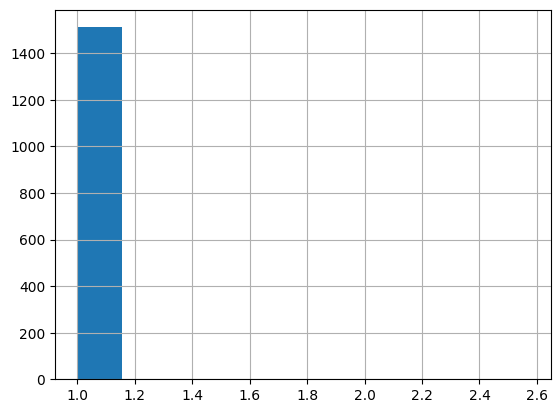

In [ ]:
#gets only the columns with beta or delta values
#nopis_clinton = clinton_dat_summary.filter(regex = 'delt|beta').transpose()
#nopis_clinton['r_hat'].hist()
nopis_trump = trump_dat_summary.filter(regex = 'delt|beta').transpose()
nopis_trump['r_hat'].hist()



In [ ]:
#this is the posterior data produced using 500, samples, 500 burn in and 4 chains
#writing data to csv's
#fiveh_samps.to_csv( 'fiveh samps.csv')
#fiveh_summary.to_csv('fiveh summary.csv')
#fiveh_s_t.to_csv('fiveh summary_transposed.csv')

In [ ]:
#writing data to csv's
#clinton_dat_summary.to_csv('10k_samps16w_filtered_polls_summary.csv')
#clinton_dat_s_t.to_csv('10k_samps16w_filtered_polls_s_t.csv')

In [ ]:
clinton_deltas = clinton_dat_summary.filter(like = 'delt').T
#trump_deltas = tump_dat_summary.filter(like = 'delt').T

Text(0, 0.5, 'Posterior Mean Delta')

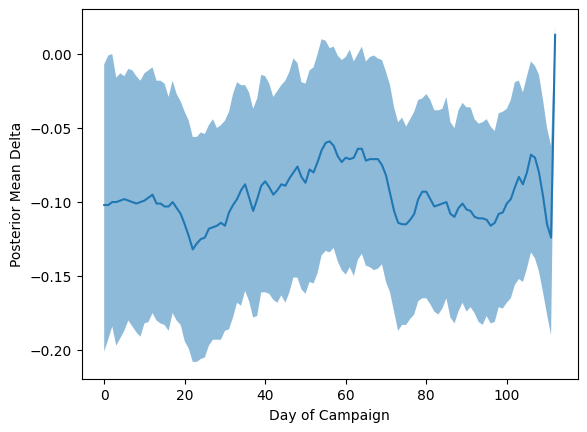

In [ ]:

axis = np.linspace(0, 112,113)
plt.plot(axis, np.flip(clinton_deltas['mean']))
plt.fill_between(axis,
                 np.flip(clinton_deltas['hdi_97%']),
                 np.flip(clinton_deltas['hdi_3%']),
                 alpha = 0.5)
plt.xlabel('Day of Campaign')
plt.ylabel('Posterior Mean Delta')


In [ ]:
#trump deltas plot
axis = np.linspace(0, 112,113)
plt.plot(axis, np.flip(trump_deltas['mean']))
plt.fill_between(axis,
                 np.flip(trump_deltas['hdi_97%']),
                 np.flip(trump_deltas['hdi_3%']),
                 alpha = 0.5)
plt.xlabel('Day of Campaign')
plt.ylabel('Posterior Mean Delta')


# Calculating Coverage Probabilities

In [ ]:
#loading in electiion results
tmp_results = pd.read_csv('/content/drive/MyDrive/Election Data/2016 Election Results.csv', sep=',', header = 0)
results = np.column_stack((states, tmp_results[['Clinton', 'Trump']]/100))

In [ ]:
#to loop over when filtering for coverage probabilities
pis = []
pi_1 = 'pis['
pi_2 = ','
for i in range(50):
  pis.append(pi_1 + str(i) + pi_2)

In [ ]:
#clinton coverage probabilities
clinton_share = results[:,1]
clinton_cov_list = []
for i in range(112):
  tmp_cov = []
  for j in range(50):
    p = clinton_share[j]
    tmpl = clinton_dat_summary.filter(like = pis[j]).T
    tmp_cov.append((tmpl['hdi_97%'][i] >= p) & (tmpl['hdi_3%'][i] <= p))
  clinton_cov_list.append(sum(tmp_cov)/50)


In [ ]:
#trump coverage probabilities
trump_share = results[:,2]
trump_cov_list = []
for i in range(112):
  tmp_cov = []
  for j in range(50):
    p = trump_share[j]
    tmpl = trump_dat_summary.filter(like = pis[j]).T
    tmp_cov.append((tmpl['hdi_97%'][i] >= p) & (tmpl['hdi_3%'][i] <= p))
  trump_cov_list.append(sum(tmp_cov)/50)

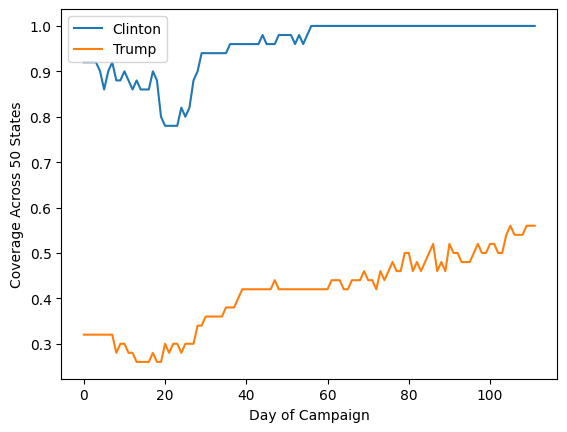

In [ ]:
axis = np.linspace(0, 111,112)
plt.plot(axis, np.flip(clinton_cov_list), label = 'Clinton')
plt.plot(axis, np.flip(trump_cov_list), label = 'Trump')
plt.xlabel('Day of Campaign')
plt.ylabel('Coverage Across 50 States')
plt.legend()

# Swing-State Plot Data

In [ ]:
#AZ, COL, FL, GA, IA,  MI, MIN, NV, NH, NM, NC, OH, OR, PA, VA, WI are indexed by
# 2,  5,  8,  9,   14, 21, 22,  27, 28, 30, 32, 34, 36, 37, 45, 48 (alphabetical order)
clinton_plot_dat = []
for i in ['pis[2, ','pis[5, ', 'pis[8, ', 'pis[9, ', 'pis[14, ', 'pis[21, ','pis[22, ','pis[27, ','pis[28, ',
          'pis[30, ', 'pis[32, ','pis[34, ','pis[36, ', 'pis[37, ','pis[45, ', 'pis[48, ']:
   clinton_plot_dat.append(clinton_dat_summary.filter(like = i).iloc[:,::-1].T)


In [ ]:
#change this code if you want to plot poll data
adjpolls_dat = []
for i in [2,5,8,9,14,21,22,27,28,30,32,34,36,37,45, 48]:
  tmp = np.row_stack(third_master_list_16[i])
  adjpolls_dat.append(np.flip(tmp[:,1]/tmp[:,0]))

In [ ]:
trump_plot_dat = []
for i in ['pis[2, ','pis[5, ', 'pis[8, ', 'pis[9, ', 'pis[14, ', 'pis[21, ','pis[22, ','pis[27, ','pis[28, ',
          'pis[30, ', 'pis[32, ','pis[34, ','pis[36, ', 'pis[37, ','pis[45, ', 'pis[48, ']:
   trump_plot_dat.append(trump_dat_summary.filter(like = i).iloc[:,::-1].T)


In [ ]:
#change this code if you want to plot poll data
trump_polls_dat = []
for i in [2,5,8,9,14,21,22,27,28,30,32,34,36,37,45, 48]:
  tmp = np.row_stack(trump_master_list_16[i])
  trump_polls_dat.append(np.flip(tmp[:,1]/tmp[:,0]))

# Swing State Plots (Very Messy) Use Plot Function After This Section Instead: This code is kept here since it was used in my presentation


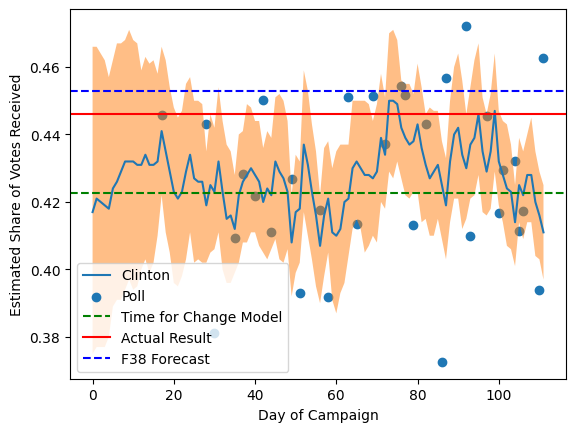

In [ ]:
#AZ plot
axis = np.linspace(0, 111,112)
plt.plot(axis, clinton_plot_dat[0]['mean'], label = 'Clinton')
#plt.scatter(axis, polls_dat[0], label = 'raw')
plt.scatter(axis, adjpolls_dat[0], label = 'Poll')
#time for change forecast
plt.axhline(y = h_i[2], linestyle = '--', color = 'g', label = 'Time for Change Model')
#actual
plt.axhline(y = .446, color = 'r', label = 'Actual Result')
plt.axhline(y = .453, linestyle = '--', color = 'b', label = 'F38 Forecast')
plt.fill_between(axis,
                clinton_plot_dat[0]['hdi_97%'],
                 clinton_plot_dat[0]['hdi_3%'],
                 alpha = 0.5)

plt.xlabel('Day of Campaign')
plt.ylabel('Estimated Share of Votes Received')
plt.legend()

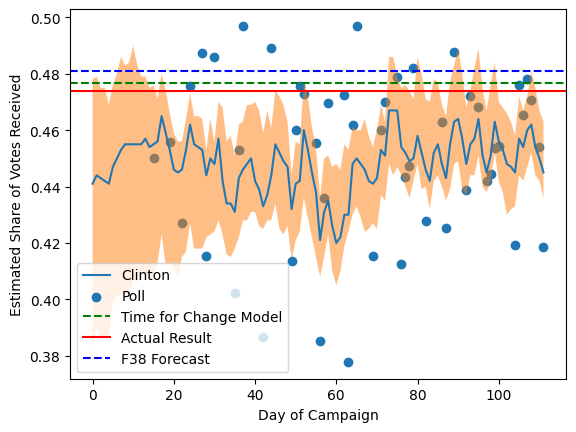

In [ ]:
#FL Plot
plt.plot(axis, clinton_plot_dat[2]['mean'], label = 'Clinton')
#plt.plot(axis, trump_plot_dat[2]['mean'], label = 'Trump')
#plt.scatter(axis, polls_dat[1], label = 'raw')
plt.scatter(axis, adjpolls_dat[2], label = 'Poll')
#time for change forecast
plt.axhline(y = h_i[8], linestyle = '--', color = 'g', label = 'Time for Change Model')
#actual
plt.axhline(y = .474, color = 'r', label = 'Actual Result')
plt.axhline(y = .481, linestyle = '--', color = 'b', label = 'F38 Forecast')
plt.fill_between(axis,
                 clinton_plot_dat[1]['hdi_97%'],
                 clinton_plot_dat[1]['hdi_3%'],
                 alpha = 0.5)
plt.xlabel('Day of Campaign')
plt.ylabel('Estimated Share of Votes Received')
plt.legend()

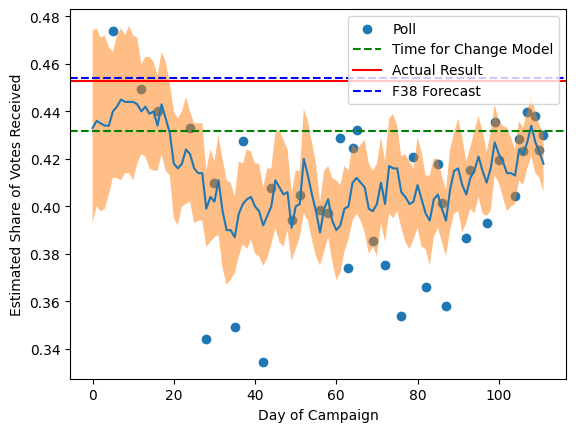

In [ ]:
#GA Plot
plt.plot(axis, clinton_plot_dat[2]['mean'])
plt.scatter(axis, adjpolls_dat[2], label = 'Poll')
#time for change forecast
plt.axhline(y = h_i[9], linestyle = '--', color = 'g', label = 'Time for Change Model')
#actual
plt.axhline(y = .453, color = 'r', label = 'Actual Result')
plt.axhline(y = .454, linestyle = '--', color = 'b', label = 'F38 Forecast')
plt.fill_between(axis,
                 clinton_plot_dat[2]['hdi_97%'],
                 clinton_plot_dat[2]['hdi_3%'],
                 alpha = 0.5)
plt.xlabel('Day of Campaign')
plt.ylabel('Estimated Share of Votes Received')
plt.legend()

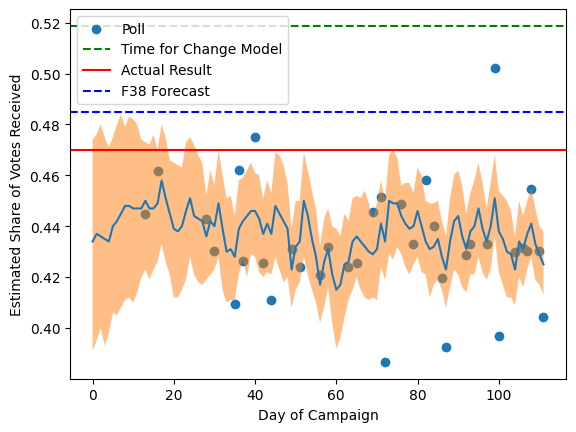

In [ ]:
plt.plot(axis, clinton_plot_dat[3]['mean'])
plt.scatter(axis, adjpolls_dat[3], label = 'Poll')
#time for change forecast
plt.axhline(y = h_i[21], linestyle = '--', color = 'g', label = 'Time for Change Model')
#actual
plt.axhline(y = .47, color = 'r', label = 'Actual Result')
plt.axhline(y = .485, linestyle = '--', color = 'b', label = 'F38 Forecast')
plt.fill_between(axis,
                 clinton_plot_dat[3]['hdi_97%'],
                 clinton_plot_dat[3]['hdi_3%'],
                 alpha = 0.5)
plt.xlabel('Day of Campaign')
plt.ylabel('Estimated Share of Votes Received')
plt.legend()

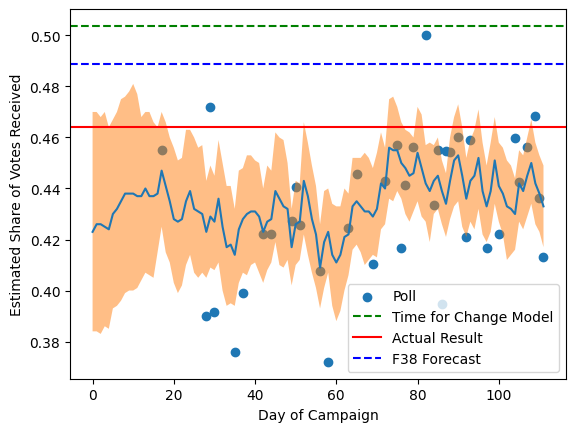

In [ ]:
plt.plot(axis, clinton_plot_dat[5]['mean'])
plt.scatter(axis, adjpolls_dat[5], label = 'Poll')
#time for change forecast
plt.axhline(y = h_i[22], linestyle = '--', color = 'g', label = 'Time for Change Model')
#actual
plt.axhline(y = .464, color = 'r', label = 'Actual Result')
plt.axhline(y = .489, linestyle = '--', color = 'b', label = 'F38 Forecast')
plt.fill_between(axis,
                 clinton_plot_dat[5]['hdi_97%'],
                 clinton_plot_dat[5]['hdi_3%'],
                 alpha = 0.5)
plt.xlabel('Day of Campaign')
plt.ylabel('Estimated Share of Votes Received')
plt.legend()

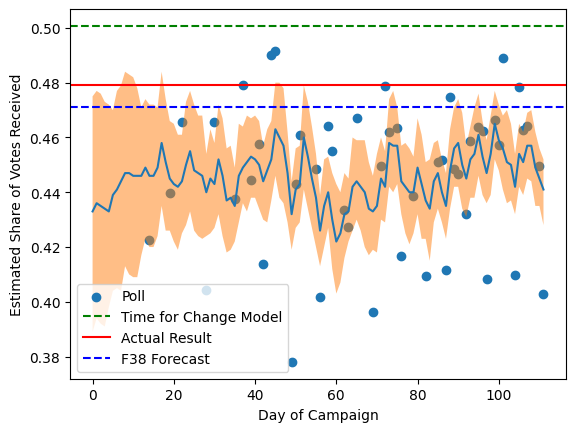

In [ ]:
plt.plot(axis, clinton_plot_dat[6]['mean'])
plt.scatter(axis, adjpolls_dat[6], label = 'Poll')
#time for change forecast
plt.axhline(y = h_i[27], linestyle = '--', color = 'g', label = 'Time for Change Model')
#actual
plt.axhline(y = .479, color = 'r', label = 'Actual Result')
plt.axhline(y = .471, linestyle = '--', color = 'b', label = 'F38 Forecast')
plt.fill_between(axis,
                 clinton_plot_dat[6]['hdi_97%'],
                 clinton_plot_dat[6]['hdi_3%'],
                 alpha = 0.5)
plt.xlabel('Day of Campaign')
plt.ylabel('Estimated Share of Votes Received')
plt.legend()

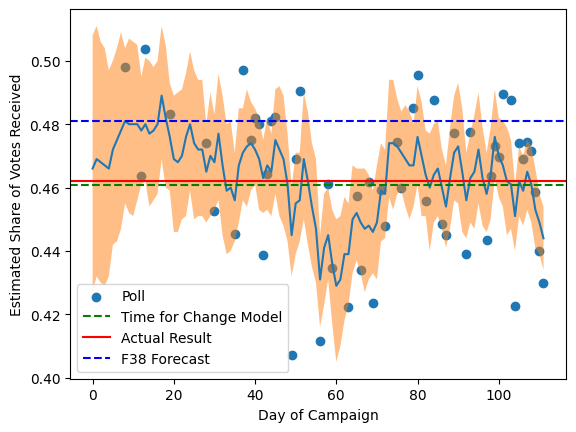

In [ ]:
plt.plot(axis, clinton_plot_dat[7]['mean'])
plt.scatter(axis, adjpolls_dat[7], label = 'Poll')
#time for change forecast
plt.axhline(y = h_i[32], linestyle = '--', color = 'g', label = 'Time for Change Model')
#actual
plt.axhline(y = .462, color = 'r', label = 'Actual Result')
plt.axhline(y = .481, linestyle = '--', color = 'b', label = 'F38 Forecast')
plt.fill_between(axis,
                 clinton_plot_dat[7]['hdi_97%'],
                 clinton_plot_dat[7]['hdi_3%'],
                 alpha = 0.5)
plt.xlabel('Day of Campaign')
plt.ylabel('Estimated Share of Votes Received')
plt.legend()

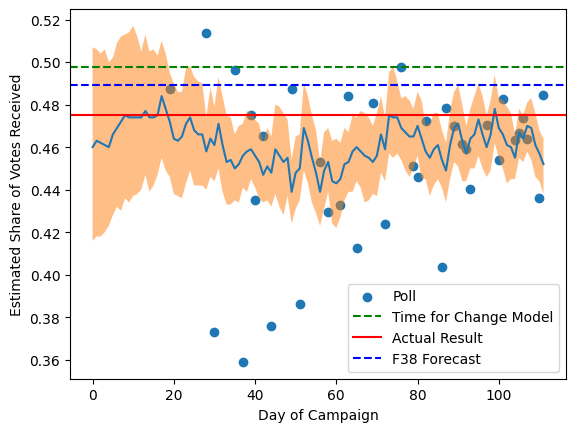

In [ ]:
plt.plot(axis, clinton_plot_dat[8]['mean'])
plt.scatter(axis, adjpolls_dat[8], label = 'Poll')
#time for change forecast
plt.axhline(y = h_i[37], linestyle = '--', color = 'g', label = 'Time for Change Model')
#actual
plt.axhline(y = .475, color = 'r', label = 'Actual Result')
plt.axhline(y = .489, linestyle = '--', color = 'b', label = 'F38 Forecast')
plt.fill_between(axis,
                 clinton_plot_dat[8]['hdi_97%'],
                 clinton_plot_dat[8]['hdi_3%'],
                 alpha = 0.5)
plt.xlabel('Day of Campaign')
plt.ylabel('Estimated Share of Votes Received')
plt.legend()

In [ ]:
#this code is from the first time I sampled with 4 chains and 1000 samples, but did not save diagnostics
#samples
#samples.to_csv('posterior samples 1.csv')

# Trump vs Clinton Plots

In [ ]:
def trumpvclinton(i = 0):
  datac = clinton_plot_dat[i]['mean']
  datat = trump_plot_dat[i]['mean']
  axis = np.linspace(0, 111,112)
  plt.plot(axis, datac, label = 'Clinton')
  plt.plot(axis, datat, label = 'Trump')
  #plt.scatter(axis, polls_dat[0], label = 'raw')
  #plt.scatter(axis, adjpolls_dat[0], label = 'Poll')
  #time for change forecast
  plt.axhline(y = results[i,1], color = 'b', label = 'Clinton Actual Result')
  plt.axhline(y = results[i,2], color = 'r', label = 'Trump Actual Result')
  plt.xlabel('Day of Campaign')
  plt.ylabel('Estimated Share of Votes Received')
  plt.legend()
  plt.show()

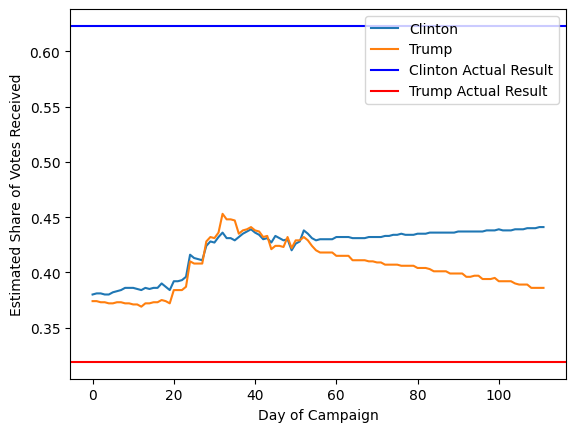

In [ ]:
#AZ, COL, FL, GA, IA,  MI, MIN, NV, NH, NM, NC, OH, OR, PA, VA, WI are indexed by
# 2,  5,  8,  9,   14, 21, 22,  27, 28, 30, 32, 34, 36, 37, 45, 48 (alphabetical order)
trumpvclinton(i = 4)

# Getting Distribution of Electoral Votes

In [ ]:
#2016 electoral vote counts for each state
elect_votes = np.array([9,3,11,6,55,9,7,3,29,16,3,4,20,11,6,6,8,8,4,10,11,16,
                     10,6,10,3,5,6,4,14,5,29,15,3,18,7,7,20,4,9,3,11,36,6,
                     3,13,8,5,10,3])

In [ ]:
#to loop over when determining electoral votes
elect_pis = []
epi_1 = 'pis.'
epi_2 = '.'
for i in range(51)[1:]:
  elect_pis.append(epi_1 + str(i) + epi_2 )

In [ ]:
clinton_elects = []
trump_elects = []
clinton_elects.append(np.ones(10000)*3)
for i in range(50):
  np.random.seed(1)
  trump_prop = np.random.choice(trump_dat.filter(like = elect_pis[i]).iloc[:, 0], 10000, replace = True)
  clinton_prop =np.random.choice(clinton_dat.filter(like = elect_pis[i]).iloc[:, 0], 10000, replace = True)
  clinton_elects.append(elect_votes[i]*(clinton_prop >= trump_prop))
  trump_elects.append(elect_votes[i]*(clinton_prop < trump_prop))
clinton_elect_array = np.column_stack(clinton_elects)
clinton_elect_dist = np.sum(clinton_elect_array, axis = 1)
trump_elect_array = np.column_stack(trump_elects)
trump_elect_dist = np.sum(trump_elect_array, axis = 1)

In [ ]:
#reality check to make sure things are working correctly
clinton_elect_dist + trump_elect_dist

array([531., 531., 531., ..., 531., 531., 531.])

Text(0, 0.5, 'Frequency')

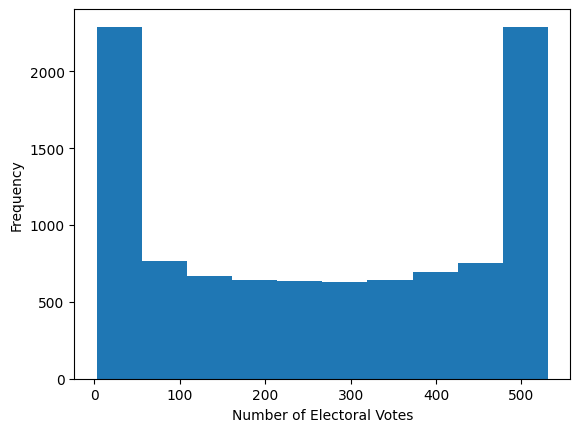

In [ ]:
#look at either distribution of electoral votes here
plt.hist(clinton_elect_dist)
plt.xlabel(r'Number of Electoral Votes')
plt.ylabel('Frequency')

In [ ]:
#calculate probability of a candidate winning here
sum(clinton_elect_dist >= 270)/10000

0.4957

In [ ]:

np.mean(clinton_elect_dist)

266.81

In [ ]:
sum(trump_elect_dist < 270)/10000

0.5069

In [ ]:
mean_clinton_elects = []
for i in range(50):
  mean_clinton_elects.append(elect_votes[i]*(clinton_dat_summary.filter(like = pis[i]).T['mean'][i] >
  trump_dat_summary.filter(like = pis[i]).T['mean'][i]))
sum(mean_clinton_elects) + 3


274

# Creating Forecasts By Direct Comparison Of Posterior Samples

In [ ]:
#estimating the probability of winning on day j by sampling from
# both posteriors and comparing
clinton_probs = []
for i in range(50):
  clinton_tmp = clinton_dat.filter(like = elect_pis[i])
  trump_tmp = trump_dat.filter(like = elect_pis[i])
  tmp_probs = []
  for j in range(112):
    trump_prop = np.random.choice(trump_tmp.iloc[:, j], 1000, replace = True)
    clinton_prop =np.random.choice(clinton_tmp.iloc[:, j], 1000, replace = True)
    tmp_probs.append(sum(clinton_prop >= trump_prop)/1000)
  clinton_probs.append(tmp_probs)


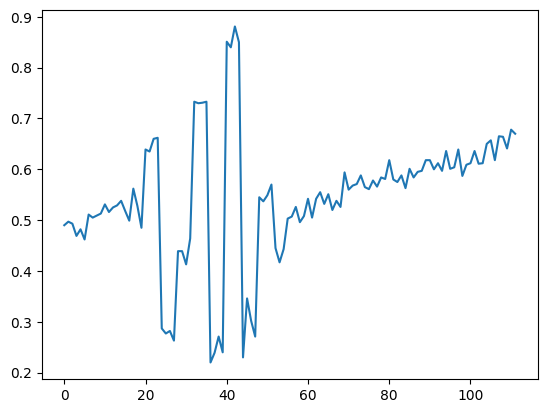

In [ ]:
axis = np.linspace(0, 111,112)
plt.plot(axis, np.flip(clinton_probs[8]))